# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

TODOs:
- Test first layer as a binary classification (attack/benign)
- Test limiting weights
- Test dropping Protocol feature
- Test adding a feature indicating the highest protocol layer

# Imports

In [1]:
import os
import sys
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
import utils
import model_utils
import visualization as viz

from multi_stage_classifier import MultiStageClassifier, ModelStage

constants = utils.get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

## Read datasets

In [4]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = utils.get_features_list(df)
refined_features_list = utils.get_features_list(df_refined)

# features_list.remove('Protocol Type')
# refined_features_list.remove('Protocol Type')

# Baseline

## Binary Classification - Attack / Benign flow

In [6]:
%%time

is_attack = (df.general_label != 'Benign').map({
    True: 'Attack',
    False: 'Benign'
}).astype('category')

binary_baseline_df_split = model_utils.get_train_test_split(
    df,
    target=is_attack,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 20.3 s, sys: 4.3 s, total: 24.6 s
Wall time: 24.5 s


Execution time (Model fit): 0:01:04.980771
Execution time (Predict): 0:00:01.085655
              precision    recall  f1-score   support

      Attack     0.9990    0.9985    0.9987    976549
      Benign     0.9398    0.9567    0.9482     23451

    accuracy                         0.9975   1000000
   macro avg     0.9694    0.9776    0.9735   1000000
weighted avg     0.9975    0.9975    0.9975   1000000

CPU times: user 27min 22s, sys: 20.3 s, total: 27min 42s
Wall time: 1min 13s


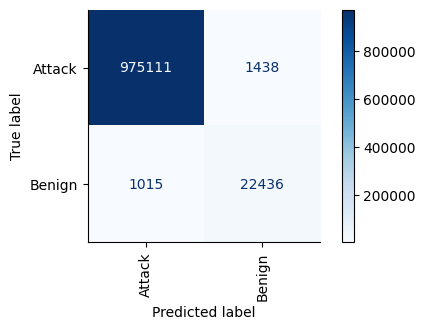

In [8]:
%%time

binary_model_baseline = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = binary_baseline_df_split

model_utils.train_model(binary_model_baseline, X_train, y_train)
model_utils.evaluate_model(binary_model_baseline, X_test, y_test)

## 7+1 Classes

In [10]:
%%time

simplified_baseline_df_split = model_utils.get_train_test_split(
    df,
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 15.6 s, sys: 4.04 s, total: 19.6 s
Wall time: 19.6 s


Execution time (Model fit): 0:01:36.189339
Execution time (Predict): 0:00:02.749440
              precision    recall  f1-score   support

      Benign     0.9149    0.9781    0.9455     23666
  BruteForce     1.0000    0.5162    0.6810       277
        DDoS     0.9999    1.0000    0.9999    727738
         DoS     0.9998    0.9998    0.9998    173280
       Mirai     0.9999    0.9998    0.9999     56693
       Recon     0.8945    0.8196    0.8554      7510
    Spoofing     0.9062    0.8521    0.8783     10338
         Web     0.9882    0.3373    0.5030       498

    accuracy                         0.9961   1000000
   macro avg     0.9629    0.8129    0.8578   1000000
weighted avg     0.9961    0.9961    0.9961   1000000

CPU times: user 39min 17s, sys: 15.4 s, total: 39min 32s
Wall time: 1min 44s


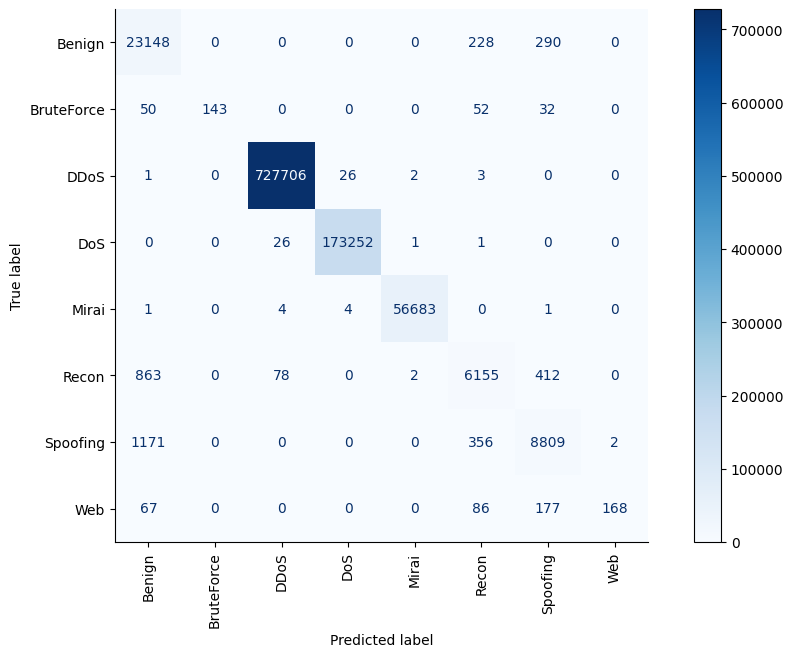

In [11]:
%%time

simplified_model_baseline = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_baseline_df_split

model_utils.train_model(simplified_model_baseline, X_train, y_train)
model_utils.evaluate_model(simplified_model_baseline, X_test, y_test)

## 33+1 Classes

In [21]:
%%time

baseline_df_split = model_utils.get_train_test_split(
    df,
    target='label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 16.4 s, sys: 4.18 s, total: 20.5 s
Wall time: 20.5 s


Execution time (Model fit): 0:01:37.043195
Execution time (Predict): 0:00:10.258931
                         precision    recall  f1-score   support

       Backdoor_Malware     0.6667    0.0286    0.0548        70
          BenignTraffic     0.8929    0.9881    0.9381     23570
       BrowserHijacking     0.9615    0.1799    0.3030       139
       CommandInjection     0.8387    0.2385    0.3714       109
 DDoS-ACK_Fragmentation     0.9951    0.9966    0.9958      6122
        DDoS-HTTP_Flood     0.9897    0.9664    0.9779       595
        DDoS-ICMP_Flood     0.9999    0.9999    0.9999    154353
DDoS-ICMP_Fragmentation     0.9946    0.9989    0.9967      9704
      DDoS-PSHACK_Flood     0.9999    0.9997    0.9998     87963
       DDoS-RSTFINFlood     0.9999    0.9995    0.9997     86148
         DDoS-SYN_Flood     0.9997    0.9996    0.9996     86862
         DDoS-SlowLoris     0.9404    0.9800    0.9598       499
DDoS-SynonymousIP_Flood     0.9996    0.9994    0.9995     76759
     

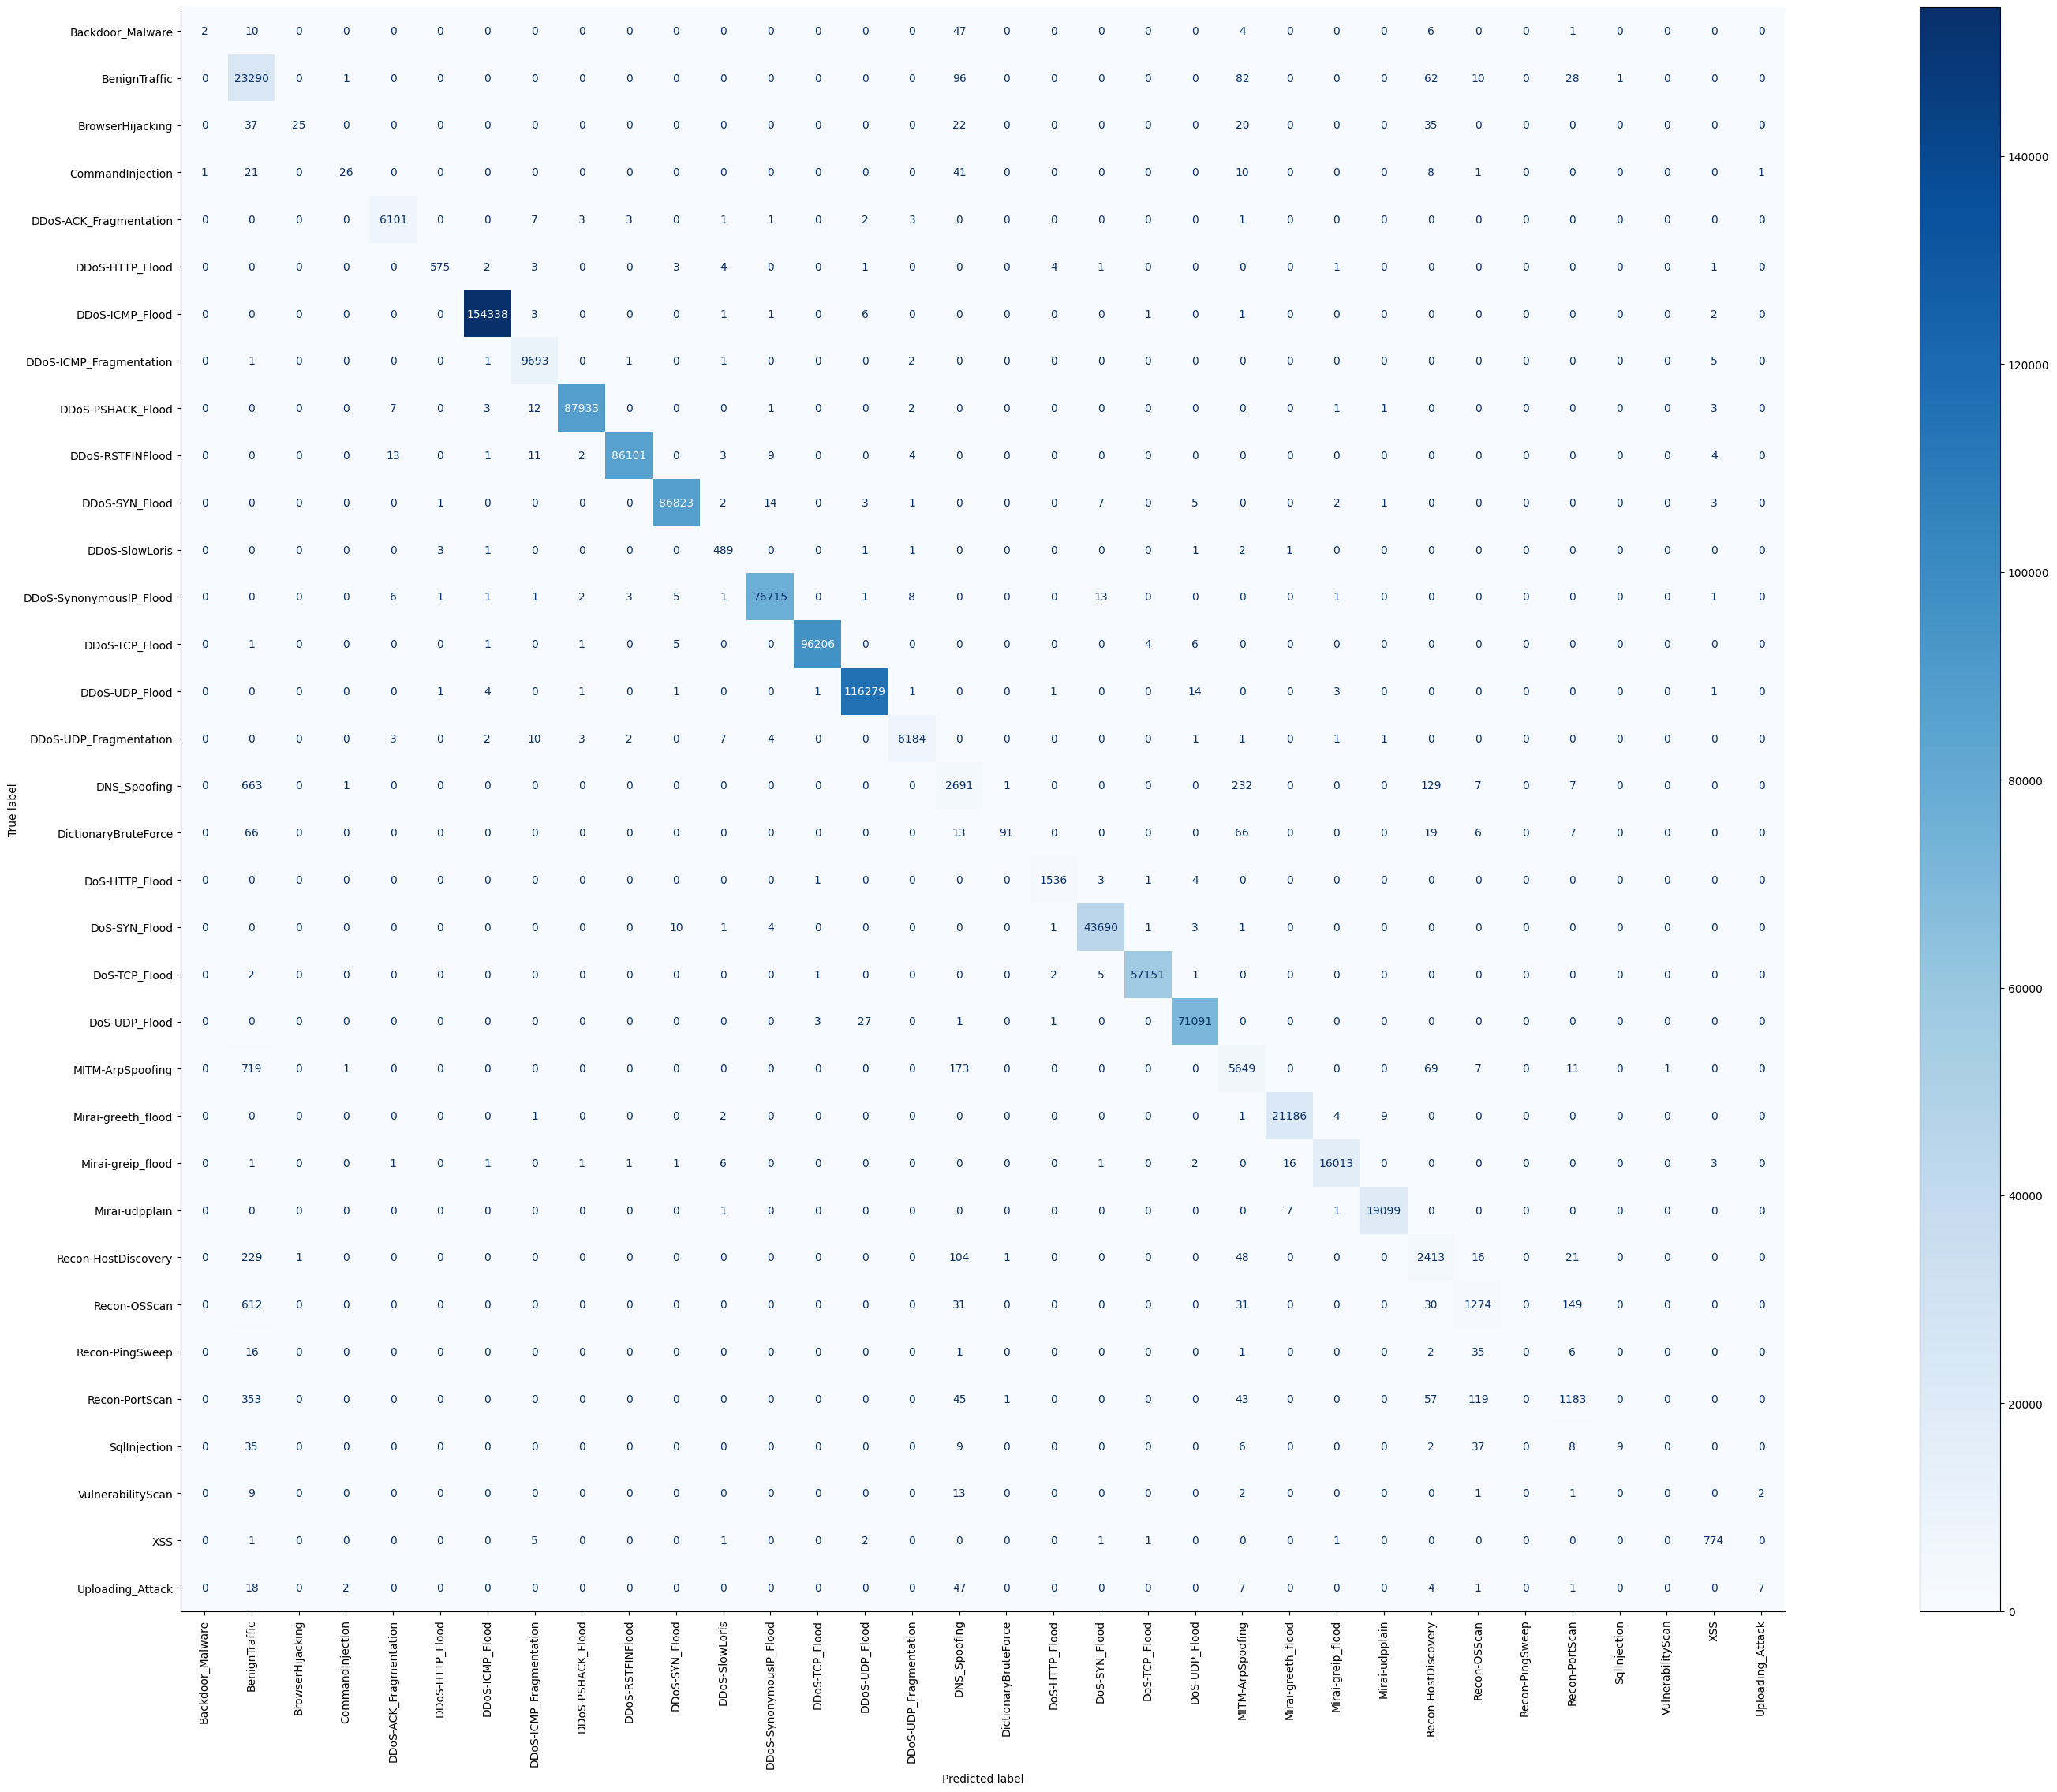

In [32]:
%%time

model_baseline = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = baseline_df_split

model_utils.train_model(model_baseline, X_train, y_train)
model_utils.evaluate_model(model_baseline, X_test, y_test)

## Open questions from the EDA

### Model without duplicates

In [15]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop_duplicates(),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 4min 36s, sys: 31.4 s, total: 5min 7s
Wall time: 5min 7s


Execution time (Model fit): 0:01:49.125567
Execution time (Predict): 0:00:02.886750
              precision    recall  f1-score   support

      Benign     0.9152    0.9774    0.9453     39064
  BruteForce     1.0000    0.4793    0.6480       434
        DDoS     0.9997    0.9999    0.9998    625356
         DoS     0.9998    0.9997    0.9997    229134
       Mirai     0.9999    0.9999    0.9999     75332
       Recon     0.8966    0.8218    0.8576     12443
    Spoofing     0.9070    0.8596    0.8827     17351
         Web     0.9735    0.3318    0.4949       886

    accuracy                         0.9935   1000000
   macro avg     0.9615    0.8087    0.8535   1000000
weighted avg     0.9935    0.9935    0.9935   1000000

CPU times: user 48min 4s, sys: 12.5 s, total: 48min 16s
Wall time: 1min 57s


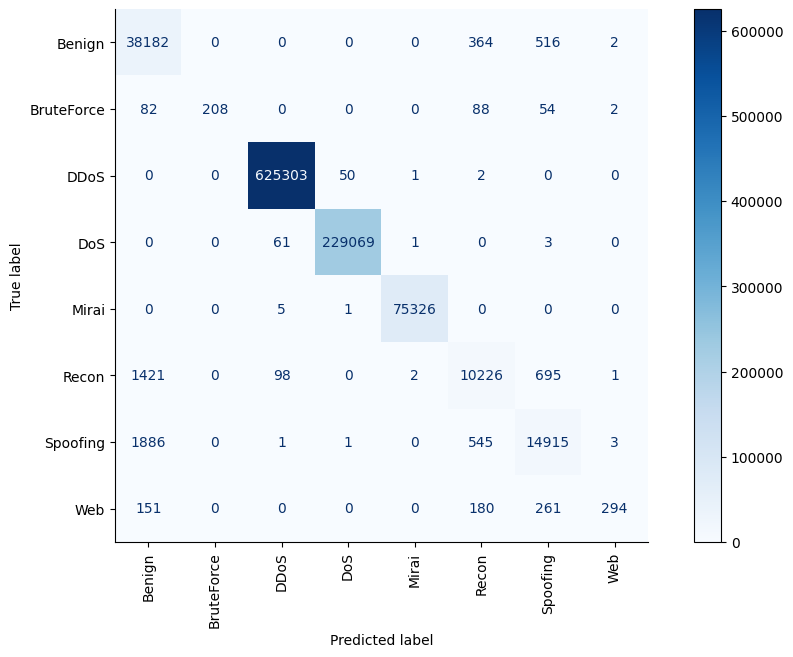

In [16]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

### Model without IAT

In [19]:
%%time

test_df_split = model_utils.get_train_test_split(
    df.drop(columns=['IAT']),
    target='general_label',
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 18.9 s, sys: 6.47 s, total: 25.3 s
Wall time: 25.3 s


Execution time (Model fit): 0:02:22.128800
Execution time (Predict): 0:00:05.881777
              precision    recall  f1-score   support

      Benign     0.8426    0.9542    0.8949     23710
  BruteForce     0.9286    0.1403    0.2437       278
        DDoS     0.9387    0.9582    0.9484    728000
         DoS     0.8079    0.7379    0.7713    172993
       Mirai     0.9993    0.9959    0.9976     56534
       Recon     0.7734    0.6749    0.7208      7453
    Spoofing     0.8288    0.7125    0.7663     10509
         Web     0.9767    0.0803    0.1484       523

    accuracy                         0.9168   1000000
   macro avg     0.8870    0.6568    0.6864   1000000
weighted avg     0.9168    0.9168    0.9168   1000000

CPU times: user 1h 3min 27s, sys: 18.5 s, total: 1h 3min 46s
Wall time: 2min 34s


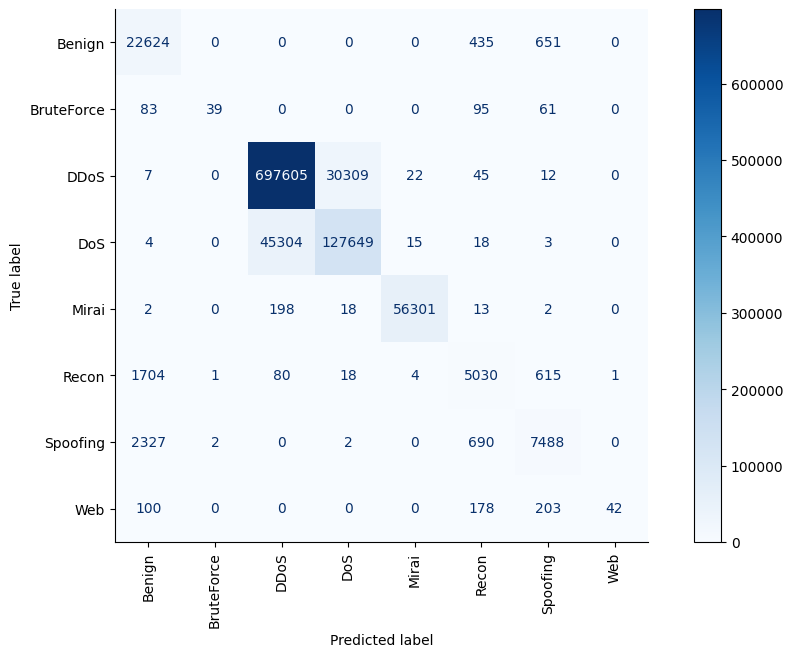

In [20]:
%%time

test_model = RandomForestClassifier(
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = test_df_split

model_utils.train_model(test_model, X_train, y_train)
model_utils.evaluate_model(test_model, X_test, y_test)

# Model (2 Stages)

In [90]:
simplified_first_layer_labels = {'DDoS', 'DoS', 'Mirai'}
simplified_second_layer_labels = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

first_layer_labels = {
    attack_type
    for layer_attack in simplified_first_layer_labels
    for attack_type in attack_category[layer_attack]
}

second_layer_labels = {
    attack_type
    for layer_attack in simplified_second_layer_labels
    for attack_type in attack_category[layer_attack]
}

## First Stage - DDoS / DoS / Mirai

Here we focus on recall... **TODO: Explain why**

### 7+1 Attacks

In [91]:
%%time

simplified_first_stage_labels = (
    df_refined.general_label
    .where(df_refined.general_label.isin(simplified_first_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=simplified_first_stage_labels,
    sample_size=5_000_000,
    train_frac=0.80
)

Training dataset size: 4.0M (80.0%).
Test dataset size: 1.0M (20.0%).
CPU times: user 16 s, sys: 3.05 s, total: 19.1 s
Wall time: 19.1 s


Execution time (Model fit): 0:02:02.201307
Execution time (Predict): 0:00:01.458533
              precision    recall  f1-score   support

      Benign     0.9999    0.9996    0.9998     42684
        DDoS     0.9999    1.0000    0.9999    727967
         DoS     0.9998    0.9998    0.9998    173206
       Mirai     1.0000    1.0000    1.0000     56143

    accuracy                         0.9999   1000000
   macro avg     0.9999    0.9998    0.9999   1000000
weighted avg     0.9999    0.9999    0.9999   1000000

CPU times: user 39min 36s, sys: 4.54 s, total: 39min 41s
Wall time: 2min 9s


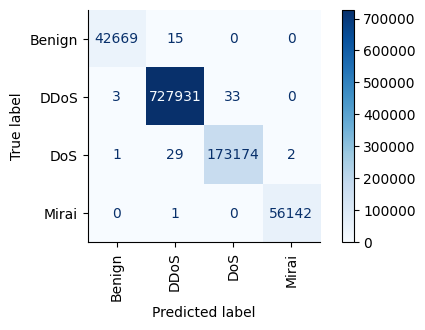

In [70]:
%%time

simplified_first_stage_model = RandomForestClassifier(
    max_features=10,
    criterion='entropy',
    class_weight='balanced',
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_first_stage_df_split

model_utils.train_model(simplified_first_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_first_stage_model, X_test, y_test)

### 33+1 Attacks

In [ ]:
%%time

first_stage_labels = (
    df_refined.label
    .where(df_refined.label.isin(first_layer_attacks), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

first_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target=first_stage_labels,
    sample_size=5_000_000,
    train_frac=0.80
)

Execution time (Model fit): 0:02:26.484395
Execution time (Predict): 0:00:05.627013
                         precision    recall  f1-score   support

          BenignTraffic     0.9995    0.9999    0.9997     42255
 DDoS-ACK_Fragmentation     0.9997    0.9998    0.9998      6067
        DDoS-HTTP_Flood     0.9984    0.9936    0.9960       625
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    154762
DDoS-ICMP_Fragmentation     1.0000    0.9992    0.9996      9744
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000     87137
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000     86512
         DDoS-SYN_Flood     0.9999    0.9999    0.9999     87732
         DDoS-SlowLoris     0.9979    0.9878    0.9928       491
DDoS-SynonymousIP_Flood     0.9999    0.9999    0.9999     77413
         DDoS-TCP_Flood     1.0000    0.9999    0.9999     96214
         DDoS-UDP_Flood     0.9997    0.9999    0.9998    116216
 DDoS-UDP_Fragmentation     0.9997    0.9997    0.9997      6186
     

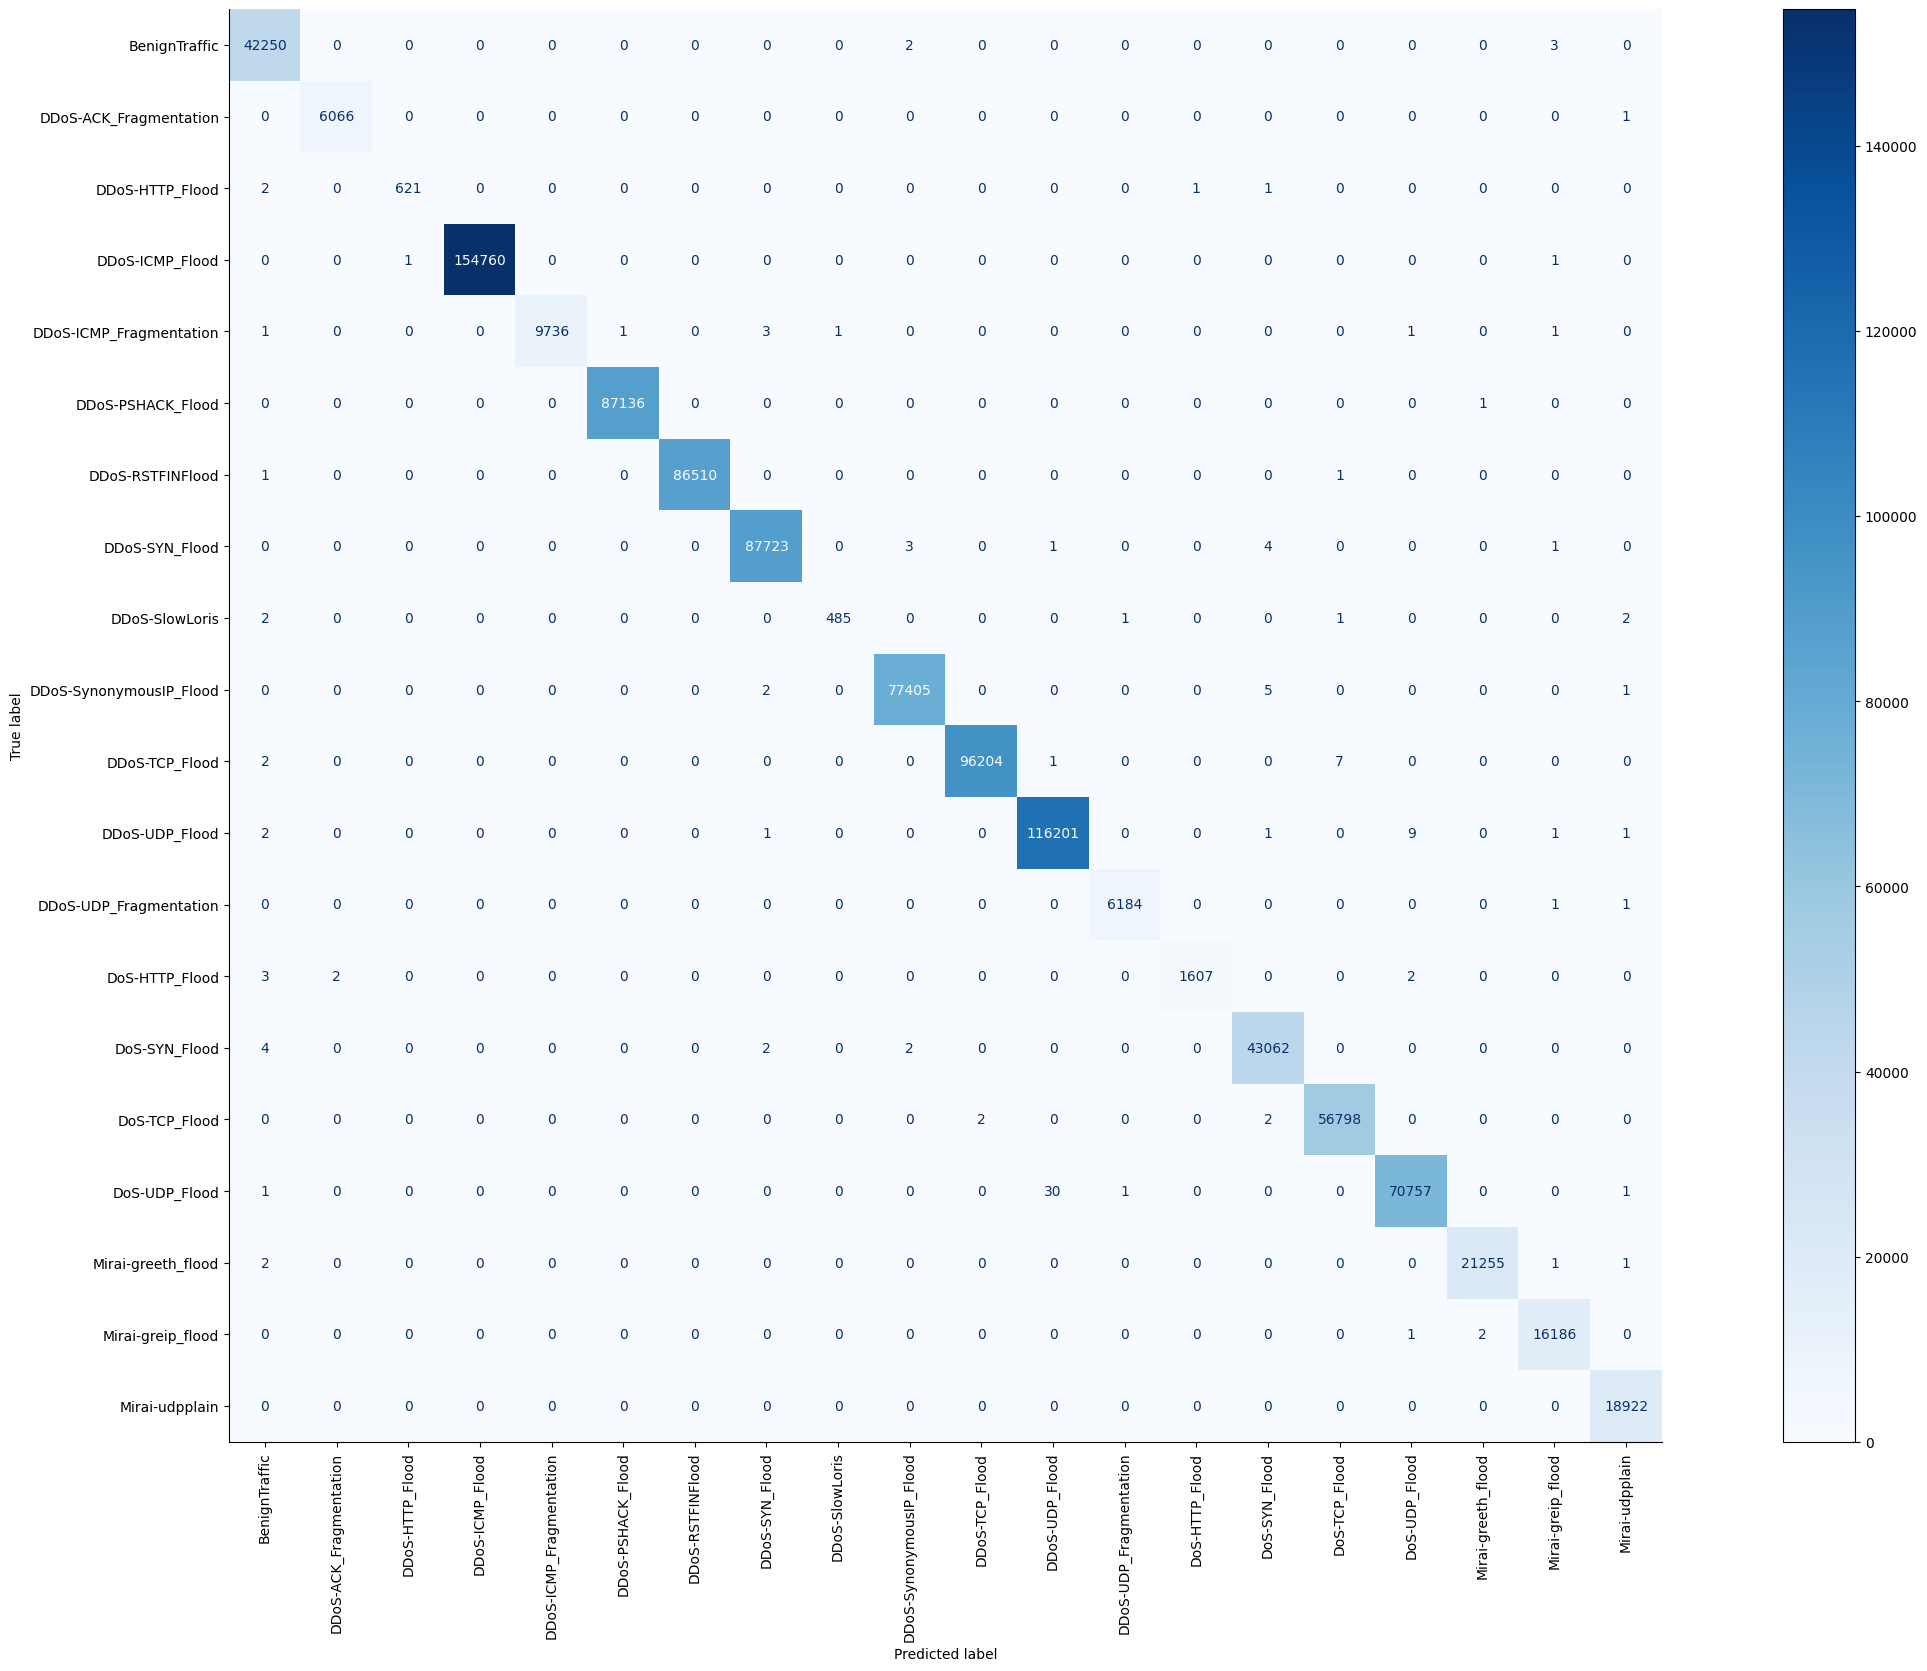

In [63]:
%%time

first_stage_model = RandomForestClassifier(
    max_features=10,
    criterion='entropy',
    class_weight='balanced',
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = first_stage_df_split

model_utils.train_model(first_stage_model, X_train, y_train)
model_utils.evaluate_model(first_stage_model, X_test, y_test)

## Second Stage - Spoofing / Recon / Web / Brute Force

In [80]:
df_second_stage = df_refined[~df_refined.general_label.isin(first_layer)]

### 7 + 1 Attacks

In [93]:
%%time

simplified_second_layer_target = (
    df_second_stage.general_label
    .where(df_second_layer.general_label.isin(simplified_second_layer_labels), 'Benign')
    .astype('category')
    .cat.remove_unused_categories()
)

simplified_second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=simplified_second_layer_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 1.35 s, sys: 131 ms, total: 1.48 s
Wall time: 1.48 s


Execution time (Model fit): 0:02:33.726586
Execution time (Predict): 0:00:01.446238
              precision    recall  f1-score   support

      Benign     0.9280    0.9818    0.9541    219566
  BruteForce     0.9827    0.6315    0.7689      2616
       Recon     0.9183    0.8623    0.8894     70611
    Spoofing     0.9351    0.8816    0.9076     97793
         Web     0.9685    0.5846    0.7291      4846

    accuracy                         0.9285    395432
   macro avg     0.9465    0.7884    0.8498    395432
weighted avg     0.9285    0.9285    0.9285    395432

CPU times: user 53min 46s, sys: 7.52 s, total: 53min 53s
Wall time: 2min 37s


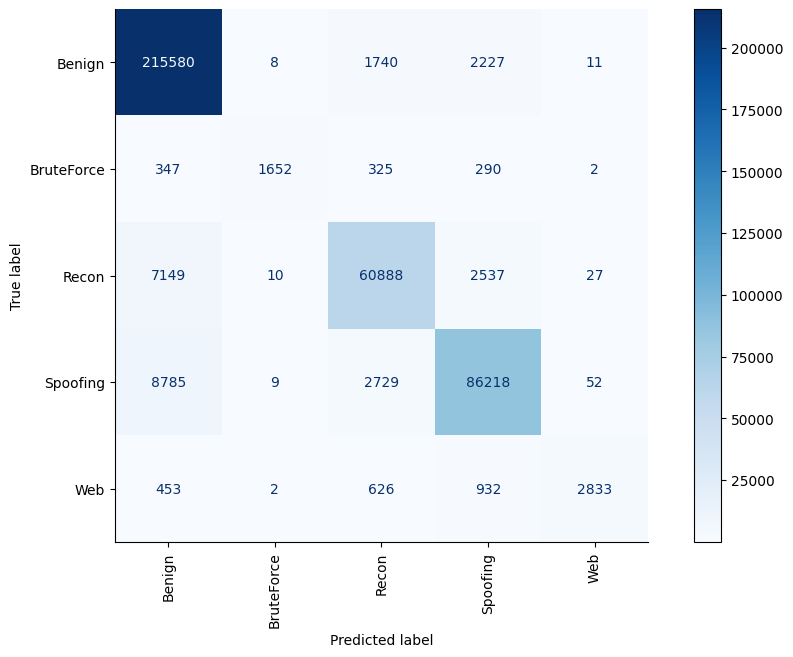

In [77]:
%%time

simplified_second_stage_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=10,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = simplified_second_stage_df_split

model_utils.train_model(simplified_second_stage_model, X_train, y_train)
model_utils.evaluate_model(simplified_second_stage_model, X_test, y_test)

### 33 + 1 Attacks

In [94]:
%%time

second_stage_target = (
    df_second_stage.label
    .where(df_second_layer.label.isin(second_layer_labels), 'BenignTraffic')
    .astype('category')
    .cat.remove_unused_categories()
)

second_stage_df_split = model_utils.get_train_test_split(
    df_second_stage,
    target=second_stage_target,
    train_frac=0.80
)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
CPU times: user 1.37 s, sys: 115 ms, total: 1.48 s
Wall time: 1.48 s


Execution time (Model fit): 0:03:20.372009
Execution time (Predict): 0:00:03.078846
                      precision    recall  f1-score   support

    Backdoor_Malware     0.9310    0.5493    0.6909       639
       BenignTraffic     0.9049    0.9902    0.9456    219566
    BrowserHijacking     0.9706    0.6237    0.7594      1164
    CommandInjection     0.9810    0.5882    0.7355      1054
        DNS_Spoofing     0.8744    0.7797    0.8243     36020
DictionaryBruteForce     0.9726    0.6372    0.7700      2616
    MITM-ArpSpoofing     0.9467    0.8647    0.9038     61773
 Recon-HostDiscovery     0.8814    0.8912    0.8863     26660
        Recon-OSScan     0.8922    0.6460    0.7494     19563
     Recon-PingSweep     0.9520    0.5420    0.6908       476
      Recon-PortScan     0.8651    0.6924    0.7692     16367
        SqlInjection     0.9614    0.5592    0.7071       980
   VulnerabilityScan     0.9917    0.4898    0.6557       245
                 XSS     1.0000    0.9999    0.

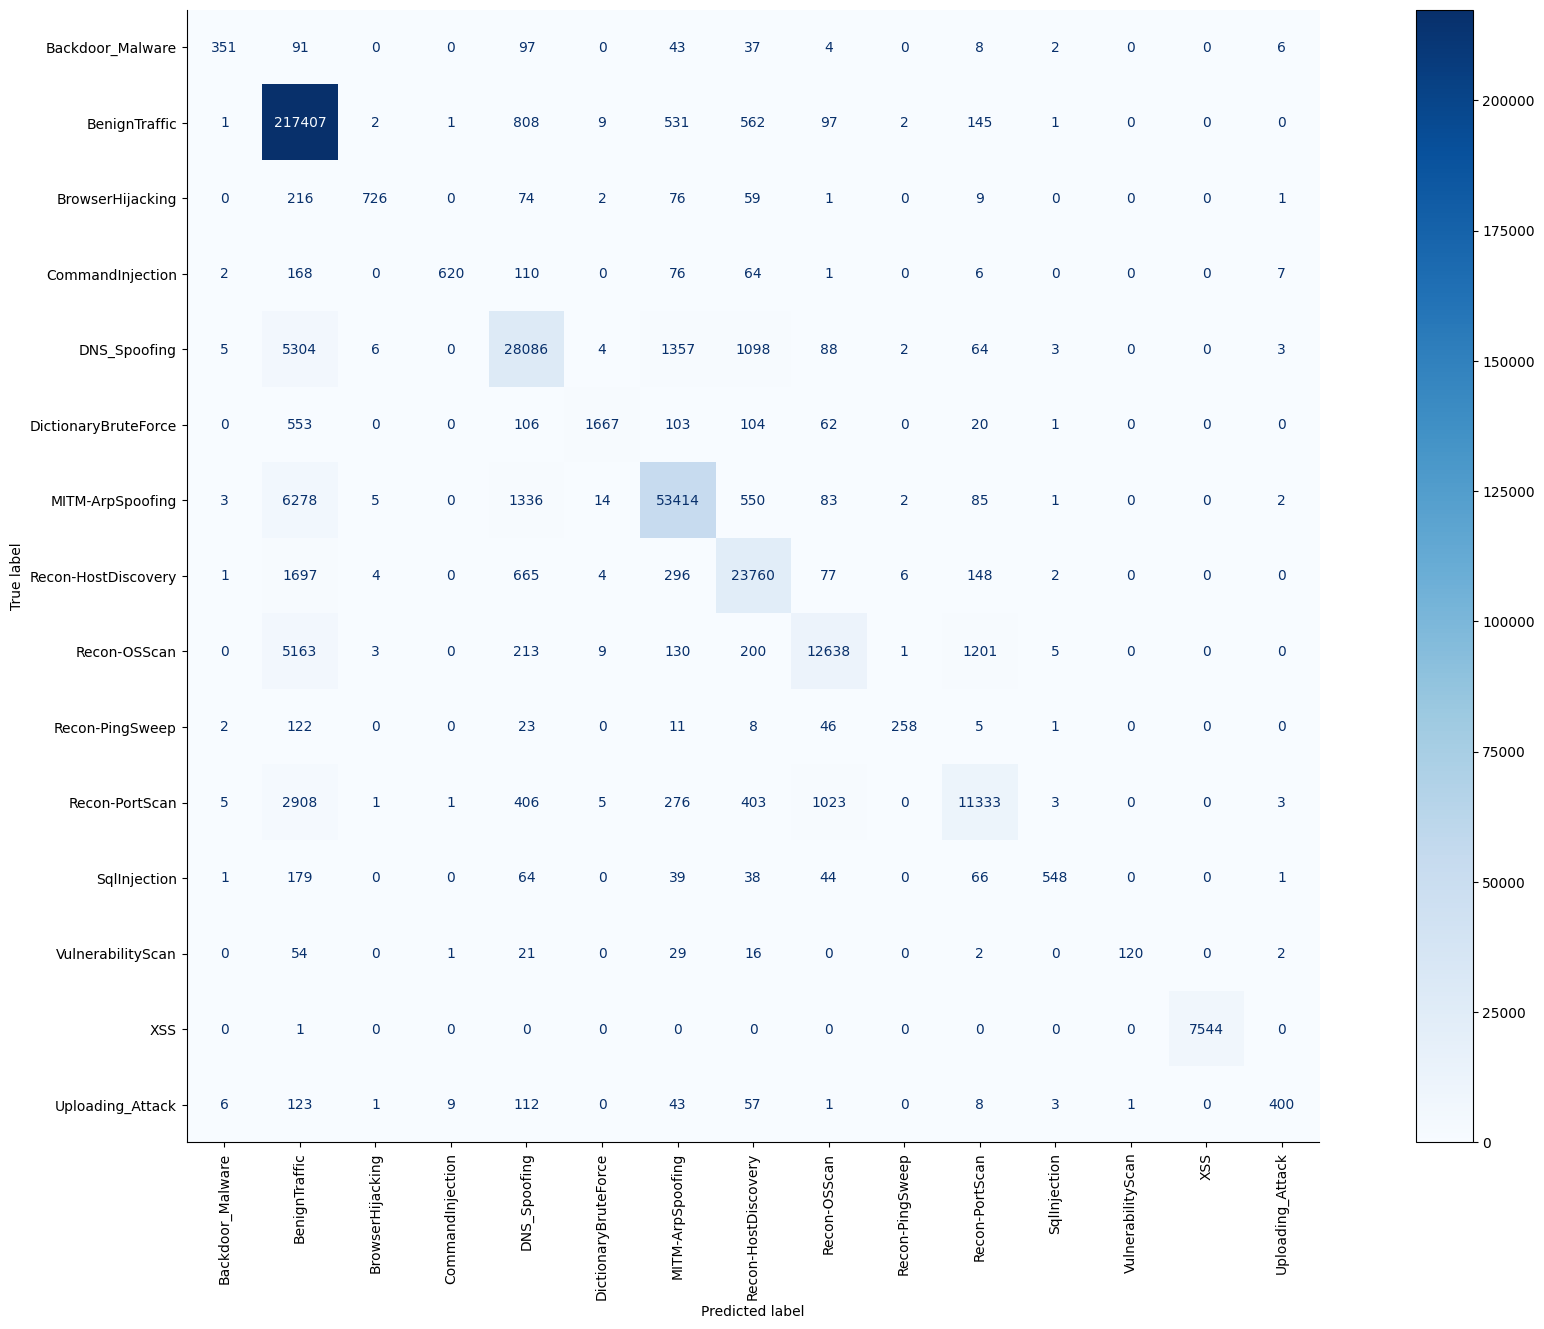

In [83]:
%%time

second_stage_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='entropy',
    max_features=10,
    n_jobs=n_jobs,
    random_state=seed
)

X_train, X_test, y_train, y_test = second_stage_df_split

model_utils.train_model(second_stage_model, X_train, y_train)
model_utils.evaluate_model(second_stage_model, X_test, y_test)

# Multi-Stage Model

### 7+1 Attacks

In [95]:
%%time

simplified_multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='general_label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 21 s, sys: 2.91 s, total: 23.9 s
Wall time: 23.9 s


Execution time (Model fit): 0:04:57.547690
Execution time (Predict): 0:00:04.395931
              precision    recall  f1-score   support

      Benign     0.9179    0.9799    0.9479     46862
  BruteForce     0.9808    0.5763    0.7260       531
        DDoS     0.9999    1.0000    1.0000   1456793
         DoS     0.9998    0.9998    0.9998    346381
       Mirai     1.0000    1.0000    1.0000    112672
       Recon     0.9125    0.8451    0.8775     15097
    Spoofing     0.9280    0.8656    0.8957     20571
         Web     0.9873    0.5682    0.7213      1093

    accuracy                         0.9966   2000000
   macro avg     0.9658    0.8543    0.8960   2000000
weighted avg     0.9966    0.9966    0.9966   2000000

CPU times: user 1h 35min 53s, sys: 52.2 s, total: 1h 36min 45s
Wall time: 5min 14s


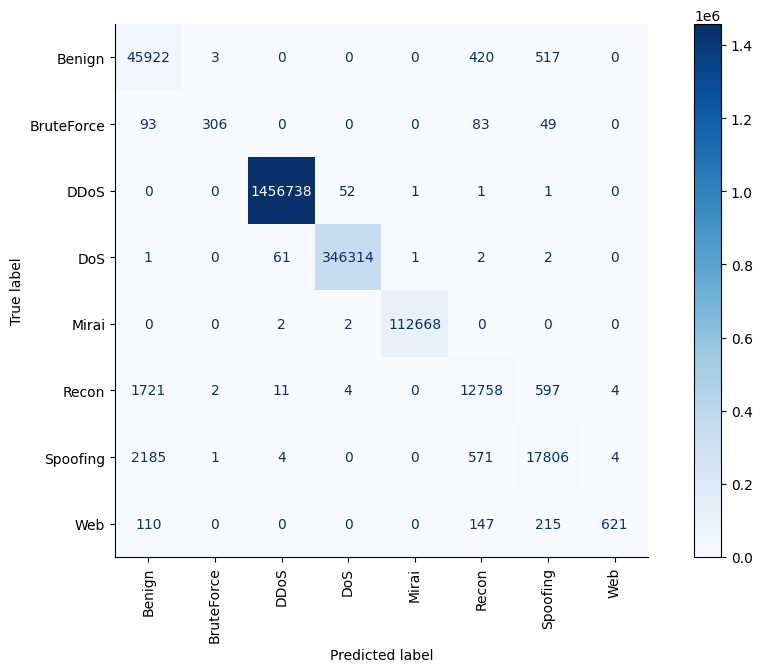

In [96]:
%%time
simplified_multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(simplified_first_stage_model, labels=simplified_first_layer_labels),
        ModelStage(simplified_second_stage_model, labels=simplified_second_layer_labels),
    ]
)

X_train, X_test, y_train, y_test = simplified_multi_stage_df_split

model_utils.train_model(simplified_multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(simplified_multi_stage_baseline_model, X_test, y_test)

### 33+1 Attacks

In [97]:
%%time

multi_stage_df_split = model_utils.get_train_test_split(
    df_refined,
    target='label',
    sample_size=10_000_000,
    train_frac=0.80
)

Training dataset size: 8.0M (80.0%).
Test dataset size: 2.0M (20.0%).
CPU times: user 21 s, sys: 2.9 s, total: 23.9 s
Wall time: 23.9 s


Execution time (Model fit): 0:06:17.743166
Execution time (Predict): 0:00:13.740040
                         precision    recall  f1-score   support

       Backdoor_Malware     0.9796    0.4174    0.5854       115
          BenignTraffic     0.8895    0.9905    0.9373     47238
       BrowserHijacking     0.9863    0.5830    0.7328       247
       CommandInjection     1.0000    0.6154    0.7619       247
 DDoS-ACK_Fragmentation     0.9999    0.9998    0.9999     12146
        DDoS-HTTP_Flood     0.9992    0.9959    0.9976      1233
        DDoS-ICMP_Flood     1.0000    1.0000    1.0000    308219
DDoS-ICMP_Fragmentation     0.9998    0.9998    0.9998     19455
      DDoS-PSHACK_Flood     1.0000    1.0000    1.0000    175670
       DDoS-RSTFINFlood     1.0000    1.0000    1.0000    172838
         DDoS-SYN_Flood     0.9999    0.9999    0.9999    173730
         DDoS-SlowLoris     0.9990    0.9979    0.9985       969
DDoS-SynonymousIP_Flood     0.9999    0.9998    0.9998    154189
     

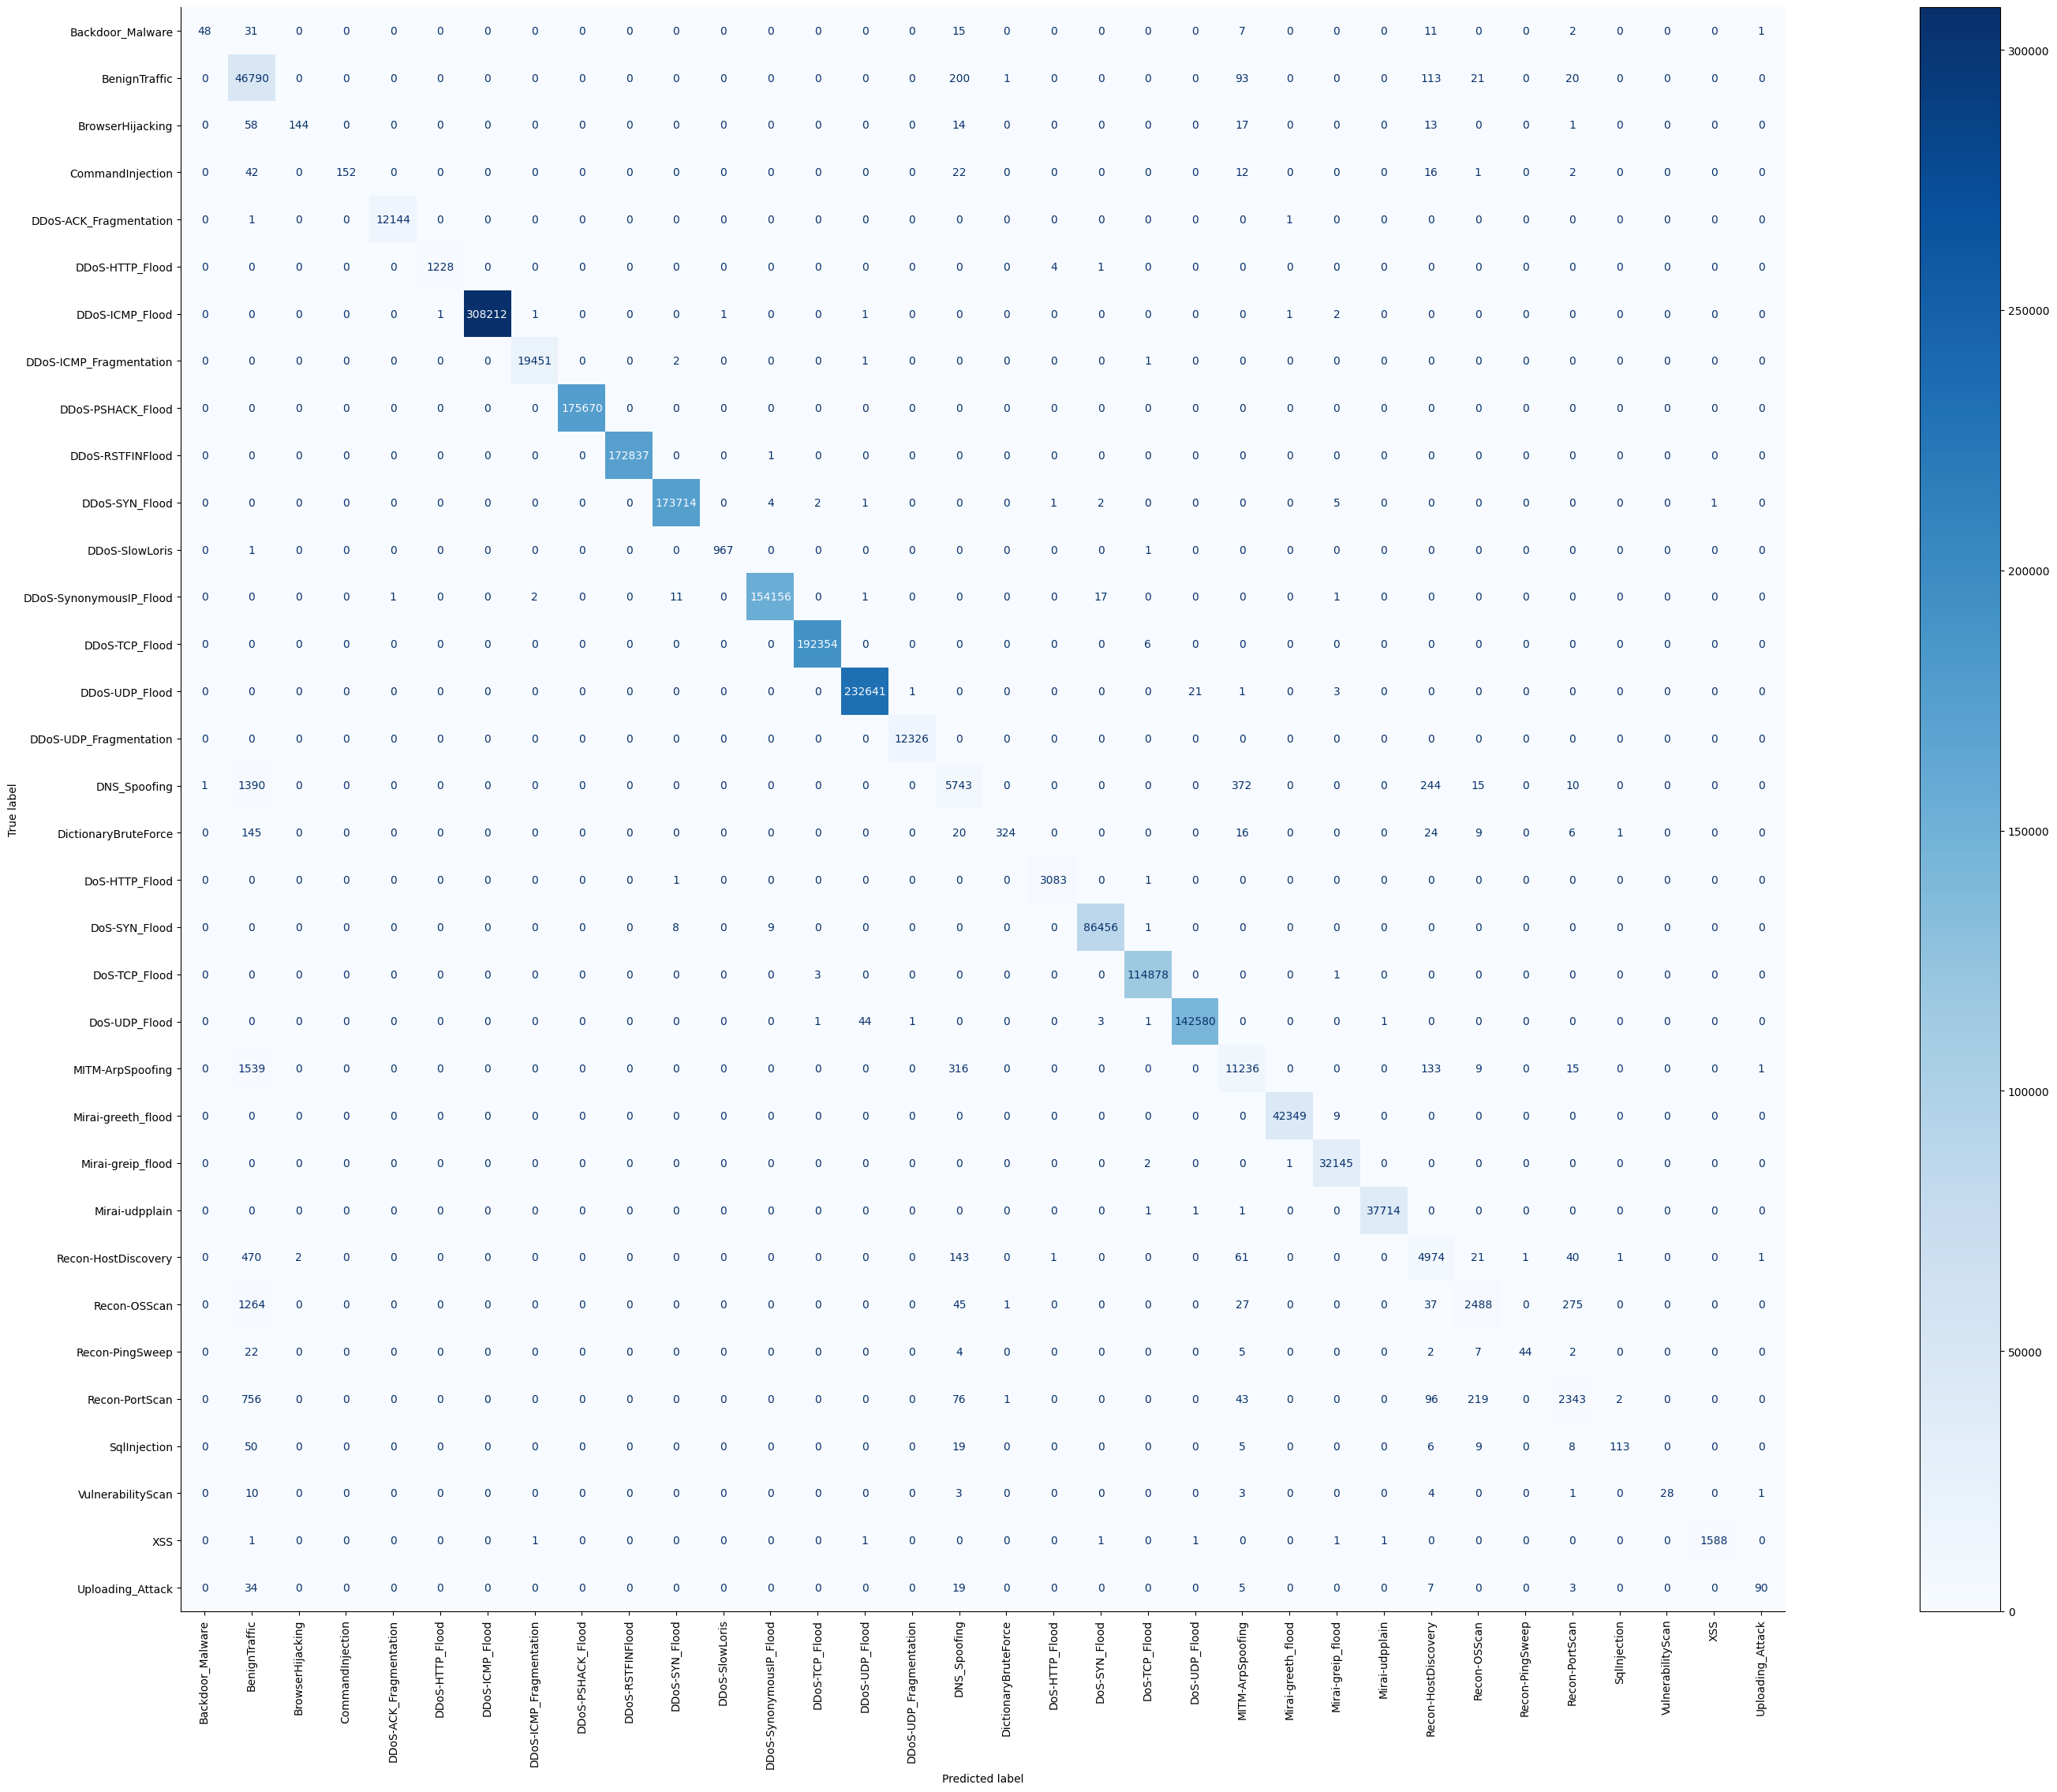

In [99]:
%%time
multi_stage_baseline_model = MultiStageClassifier(
    stages=[
        ModelStage(first_stage_model, labels=first_layer_labels),
        ModelStage(second_stage_model, labels=second_layer_labels),
    ],
    default_label='BenignTraffic'
)

X_train, X_test, y_train, y_test = multi_stage_df_split

model_utils.train_model(multi_stage_baseline_model, X_train, y_train)
model_utils.evaluate_model(multi_stage_baseline_model, X_test, y_test)